In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline

## Load and preprocess

In [339]:
# Load
with open('years.pkl', 'rb') as y, open("cites.pkl", 'rb') as c:
    X = np.asarray(pickle.load(y))
    y = np.asarray(pickle.load(c))
    
    # Remove small lists
    idx = np.where(np.asarray([len(x) for x in X]) > 4)[0]
    X = X[idx]
    y = y[idx]
    
    y = y[0:10000]
    X = X[0:10000]

In [340]:
# Preprocess shape
y_normed = [np.asarray(cites) / max(cites) for cites in y]

In [341]:
labels = np.ones(len(y)) * -1

## Prune outliers

In [342]:
residuals = []
for i in range(len(y_normed)):
    xs = np.linspace(0, 1, len(y_normed[i]))
    spline2 = UnivariateSpline(xs, y_normed[i], k=3)
    residuals.append(spline2.get_residual())

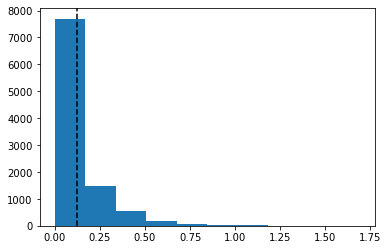

In [343]:
plt.hist(residuals)
threshold = 2*np.quantile(residuals, 0.5)
plt.axvline(threshold, ls='--', c='black')
plt.show()

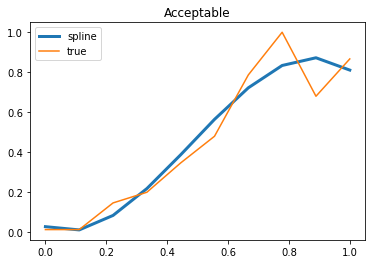

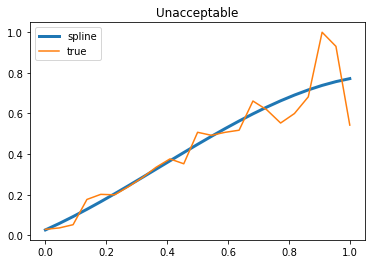

In [344]:
i = np.where(np.asarray(residuals) < threshold)[0][-1]
xs = np.linspace(0, 1, len(y_normed[i]))
spline3 = UnivariateSpline(xs, y_normed[i], k=3)
plt.plot(xs, spline3(xs), lw=3, label='spline')

plt.plot(xs, y_normed[i], label='true')
plt.legend()
plt.title('Acceptable')
plt.show()

i = np.where(np.asarray(residuals) > threshold)[0][-1]
xs = np.linspace(0, 1, len(y_normed[i]))
spline3 = UnivariateSpline(xs, y_normed[i], k=3)
plt.plot(xs, spline3(xs), lw=3, label='spline')
plt.plot(xs, y_normed[i], label='true')
plt.legend()
plt.title('Unacceptable')
plt.show()

## Determine behavior

Categories
- Only increase and only positive 2nd derivative (T1a)
- Decrease -> Increase (T1b, usually due to large slope needed)
- Increase -> decrease (T2)
- Decrease -> Increase -> decrease (T2, similar to above)
- Increase -> decrease -> increase (T3, weird behavior)
- Other (T4?)

In [345]:
labels = np.ones(len(y)) * -1
bad_idx = np.where(np.asarray(residuals) > threshold)[0]
labels[bad_idx] = 0
print(len(bad_idx) / len(residuals))

0.3095


zero2=0.15, zeros3=[-1.577  0.11 ]


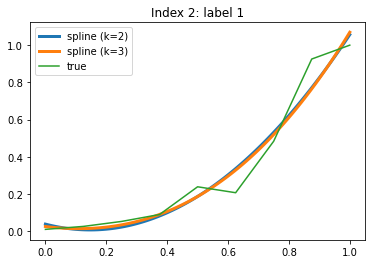

zero2=0.68, zeros3=[ 0.687 -8.192]


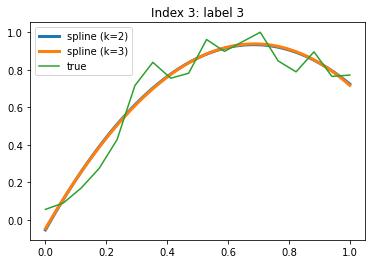

zero2=-0.02, zeros3=[]


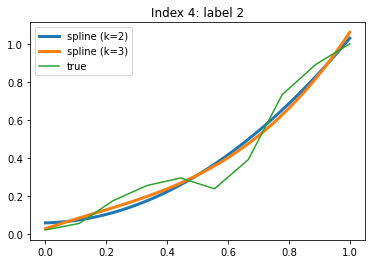

zero2=0.72, zeros3=[ 0.724 13.419]


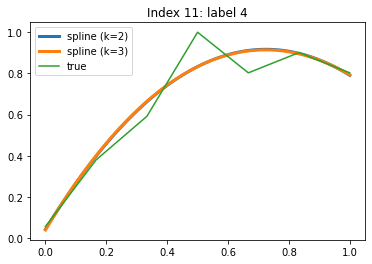

In [346]:
labels_all = np.copy(labels)
for i in range(len(labels_all)):
# for i in range(100):
    if labels[i] != -1:
        continue
    label = None
    
    # k=2 spline equation
    xs = np.linspace(0, 1, len(y_normed[i]))
    spline2 = UnivariateSpline(xs, y_normed[i], k=2)
    coeffs = spline2.derivatives(0) * [1, 1, 1/2]
    zero = -coeffs[1] / (2*coeffs[2])
    zero2 = (zero < 1 and zero > 0)
    
    # k=3 spline equation and zeros
    spline3 = UnivariateSpline(xs, y_normed[i], k=3)
    deriv1 = spline3.derivative()
    c, b, a = deriv1.derivatives(0) * [1, 1, 1/2]
    if b**2 - 4*a*c == 0:
        zeros = [-b / (2*a)]
    elif b**2 - 4*a*c > 0:
        zeros = [
            (-b - np.sqrt(b**2 - 4*a*c)) / (2*a),
            (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
        ]
    else:
        zeros = []
    zeros = np.asarray(zeros)
    zeros3 = zeros[np.where(np.logical_and(zeros > 0, zeros < 1))]

    if coeffs[2] > 0 and zero2:
        if y_normed[i][0] < 0.2 and zero < 0.4:
            # Sharp increasing
            label = 1
        else:
            label = 0
    elif coeffs[2] > -0.5 and not zero2:
        if len(zeros3) < 2:
            # Gradual increasing
            label = 2
        else:
            label = 2
    elif coeffs[2] < -1 and zero2:
        if len(zeros3) < 2 and zero < 0.7: #y_normed[i][-1] < 0.8:
            # decreases
            label = 3
        else:
            label = 4
    else:
        # plateaus
        label = 4
    
    if label not in labels_all:
        print(f'zero2={zero:.2f}, zeros3={np.round(zeros, 3)}')
        plt.plot(np.linspace(0, 1, 101), spline2(np.linspace(0, 1, 101)), lw=3, label='spline (k=2)')
        plt.plot(np.linspace(0, 1, 101), spline3(np.linspace(0, 1, 101)), lw=3, label='spline (k=3)')
        plt.plot(xs, y_normed[i], label='true')
        plt.legend()
        plt.title(f'Index {i}: label {label}')
        plt.show()

    labels_all[i] = label

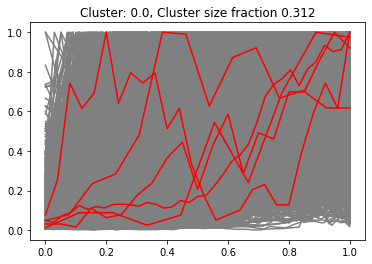

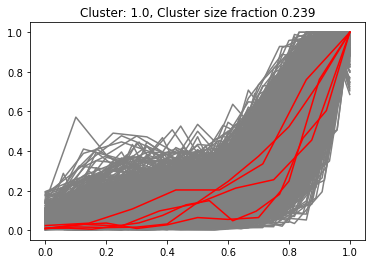

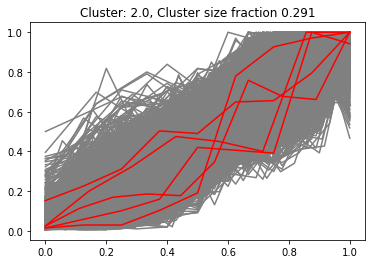

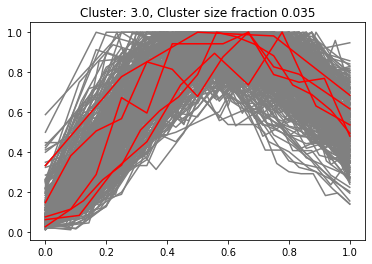

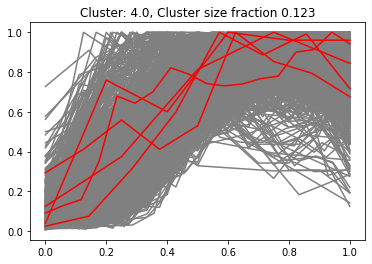

In [347]:
for label in np.unique(labels_all):
    idx = np.where(labels_all == label)[0]
    
    for i in idx:
        ts = y_normed[i]
        plt.plot(np.linspace(0, 1, len(ts)), ts, color='gray')
    
    sub_idx = np.random.choice(idx, 5)
    for i in sub_idx:
        ts = y_normed[i]
        plt.plot(np.linspace(0, 1, len(ts)), ts, color='red')
    plt.title(f'Cluster: {label}, Cluster size fraction {len(idx) / len(labels_all):.3f}')
    plt.show()

## Previous

In [311]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

In [312]:
maxLength = max(len(x) for x in X)
processed_y = []
processed_X = []
for i in range(len(y)):
    interpolated_X = np.linspace(0, 1, maxLength)
    processed_X.append(interpolated_X)
    interpolated_y = []
    processed_y.append(np.interp(interpolated_X, np.linspace(0, 1, len(y_normed[i])), y_normed[i]))

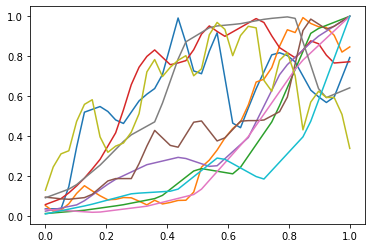

In [313]:
for i in range(10):
    plt.plot(np.linspace(0, 1, maxLength), processed_y[i])
plt.show()

In [315]:
model = TimeSeriesKMeans(n_clusters=9, metric='dtw', max_iter=20, n_jobs=-2)
model.fit(to_time_series_dataset(processed_y)[labels != 0])

TimeSeriesKMeans(max_iter=20, metric='dtw', n_clusters=9, n_jobs=-2)

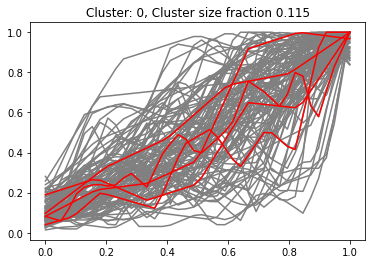

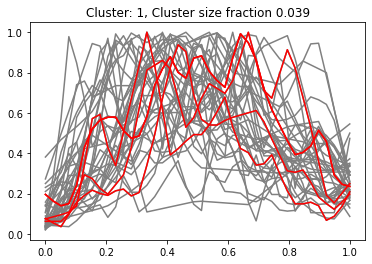

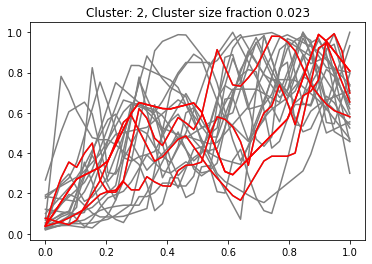

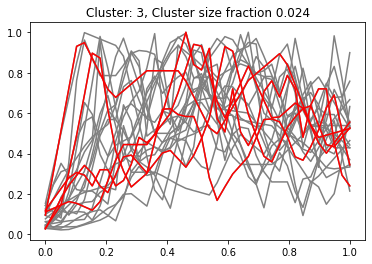

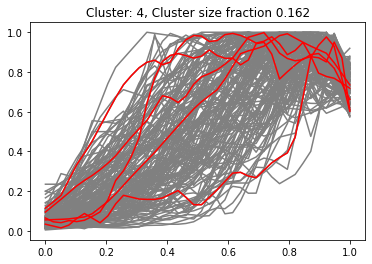

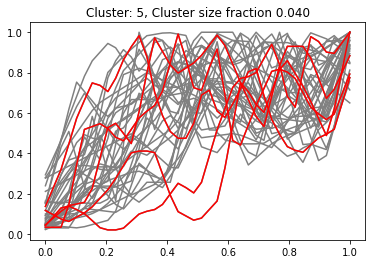

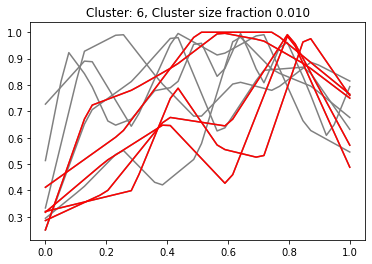

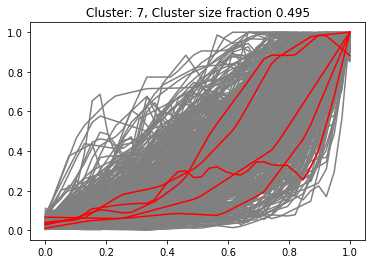

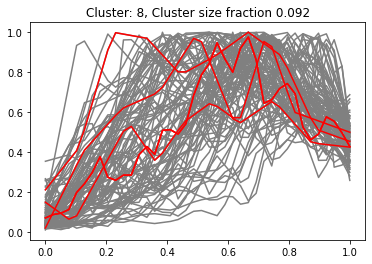

In [316]:
y_subset = np.asarray(processed_y)[labels != 0]
for label in np.unique(model.labels_):
    idx = np.where(model.labels_ == label)[0]
    
    for i in idx:
        ts = y_subset[i]
        plt.plot(np.linspace(0, 1, len(ts)), ts, color='gray')
    
    sub_idx = np.random.choice(idx, 5)
    for i in sub_idx:
        ts = y_subset[i]
        plt.plot(np.linspace(0, 1, len(ts)), ts, color='red')
    plt.title(f'Cluster: {label}, Cluster size fraction {len(idx) / len(model.labels_):.3f}')
    plt.show()